# Validation of method

### Table of contents

1. [**SVGP**](#svgp)
3. [**SSGP**](#ssgp)
4. [**Model recovery**](#fit)


This notebook contains code for:
- Investigating the number of inducing points and expressivity, degree of nonconvexity of GP models
- Multi-regressor tuning evaluation
- GP-GLM validation in population fitting
- GP marginal log-likelihood versus locally weighted log-likelihood model selection for kernel hyperparameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../lib/inference.py:521: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<a id='svgp'></a>
## SVGP

In [4]:
x_dims = 2
f_dims = 3
    
len_fx = 1.*np.ones((f_dims, x_dims))  # GP lengthscale
var_f = .1*np.ones(f_dims)  # observation noise
kern = lib.GP.kernels.SquaredExponential(f_dims, variance=var_f, lengthscale=len_fx)
mean_f = np.zeros(f_dims)
num_induc = 5
induc_locs = jax.random.normal(jax.random.PRNGKey(123), shape=(f_dims, num_induc, x_dims))

lambda_1 = 1.*jax.random.normal(jax.random.PRNGKey(123), shape=(f_dims, num_induc, 1))
chol_Lambda_2 = 1.*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)

obs = lib.GP.sparse.tSVGP(kern, mean_f, induc_locs, lambda_1, chol_Lambda_2, RFF_num_feats=100)

In [5]:
prng_state = jax.random.PRNGKey(123)
jitter = 1e-6

grid = True
n_samp = 10

if grid: # grid
    xx = np.meshgrid(*[np.linspace(-3, 3, 30) for _ in range(x_dims)])
    xx = jnp.stack(xx, axis=-1)
    
    or_shape = xx.shape[:-1]
    xx = xx.reshape(-1, 1, x_dims).repeat(n_samp, axis=1)  # (evals, samp, x_dim)
    
    pf_x = obs.sample_prior(prng_state, xx, jitter)  # (evals, samp, f_dim)
    pf_x = pf_x.reshape(*or_shape, n_samp, -1)
    
    qf_x, KL = obs.sample_posterior(prng_state, xx, jitter, compute_KL=True) # (evals, samp, f_dim)
    qf_x = qf_x.reshape(*or_shape, n_samp, -1)
    

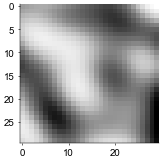

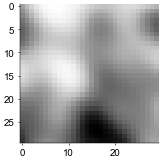

In [9]:
trs = [2, 3]
n = 0

for tr in trs:
    plt.imshow(pf_x[..., tr, n])
    plt.show()

In [12]:
x_dims = 1
f_dims = 3
    
len_fx = 1.*np.ones((f_dims, x_dims))  # GP lengthscale
var_f = .1*np.ones(f_dims)  # observation noise
kern = lib.GP.kernels.SquaredExponential(f_dims, variance=var_f, lengthscale=len_fx)
mean_f = np.zeros(f_dims)
num_induc = 10
induc_locs = jax.random.normal(jax.random.PRNGKey(123), shape=(f_dims, num_induc, x_dims))
lambda_1 = 1.*jax.random.normal(jax.random.PRNGKey(123), shape=(f_dims, num_induc, 1))
chol_Lambda_2 = 0.1*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)


obs = lib.GP.sparse.tSVGP(kern, mean_f, induc_locs, lambda_1, chol_Lambda_2, RFF_num_feats=0)

In [17]:
num_samps = 10
xx = np.linspace(-3., 3., 100)[:, None, None].repeat(num_samps, axis=1)

pf_x = obs.sample_prior(prng_state, xx, jitter)  # (evals, samp, f_dim)

qf_m, qf_c, _, _ = obs.evaluate_posterior(
    xx, mean_only=False, compute_KL=False, compute_aux=False, jitter=1e-6)

qf_x, KL = obs.sample_posterior(
    prng_state, xx, jitter, compute_KL=True) # (evals, samp, f_dim)

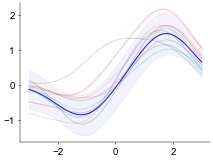

In [18]:
f_dim = 2
x_dim = 0
tr = 0

n_ps = qf_c.shape[-1]
qf_v = qf_c[f_dim, tr, np.arange(n_ps), np.arange(n_ps)]
lb = qf_m[f_dim, tr, :, 0] - 1.96 * qf_v ** 0.5
ub = qf_m[f_dim, tr, :, 0] + 1.96 * qf_v ** 0.5
m = qf_m[f_dim, tr, :, 0]
#Kzz = model.observation.compute_intermediates(None, None)['matrices'][0][f_dim, ...]
#induc_u = Kzz @ lib.utils.inv(svgp_var_params['K_prec_K'][f_dim, ...]) @ svgp_var_params['K_eta_mu'][f_dim, :, 0]


plt.plot(xx[:, 0, x_dim], m, 'b', label='posterior mean')
plt.fill_between(xx[:, 0, x_dim], lb, ub, color='b', alpha=0.05, label='95% confidence')
plt.plot(xx[:, 0, x_dim], qf_x[..., f_dim], alpha=0.3)
#plt.scatter(induc_locs[:, x_dim], induc_u)
plt.show()

<a id='ssgp'></a>
## SSGP

In [2]:
neurons = 2
num_samps = 5
prng_state = jax.random.PRNGKey(123)

jitter = 1e-6

In [26]:
f_dims = neurons
x_dims = f_dims

### state space GP ###
var_x = 1.0*np.ones((x_dims))  # GP variance
len_x = 1.0*np.ones((x_dims, 1))  # GP lengthscale

kernx = lib.GP.kernels.Matern12(x_dims, variance=var_x, lengthscale=len_x)


num_samps = 20
Tsteps = 1000

t = np.linspace(0., 5., Tsteps)  # s
timedata = (jnp.array(t), jnp.diff(t)[:1])

evalsteps = 3000
t_eval = jnp.linspace(-2., 7., evalsteps)
        

# site_init
site_obs = 0. * np.ones([Tsteps, x_dims, 1])
site_Lcov = 1. * np.eye(x_dims)[None, ...].repeat(Tsteps, axis=0)

state_space = lib.GP.markovian.FullLDS(
    kernx, site_obs, site_Lcov, diagonal_site=True)



prior_samples = state_space.sample_prior(
    prng_state, num_samps, timedata, jitter)


post_mean, post_cov, _ = state_space.evaluate_posterior(
    t_eval, timedata, mean_only=False, compute_KL=False, jitter=1e-8)
post_mean = post_mean[..., 0]

post_samples, _ = state_space.sample_posterior(
    prng_state, num_samps, timedata, t_eval, jitter, False)  # (time, tr, N)

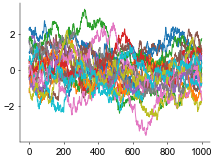

In [27]:
for n in range(num_samps):
    plt.plot(prior_samples[:, n, 1])
             
plt.show()

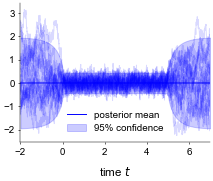

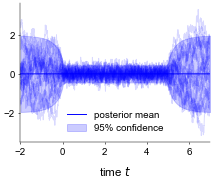

In [28]:
post_var = post_cov[:, np.arange(state_space.kernel.out_dims), np.arange(state_space.kernel.out_dims)]
lb = post_mean - 1.96 * post_var ** 0.5
ub = post_mean + 1.96 * post_var ** 0.5

for plot_out in range(state_space.kernel.out_dims):
    plt.figure()
    plt.plot(t_eval, post_mean[:, plot_out], 'b', label='posterior mean')
    plt.fill_between(t_eval, lb[:, plot_out], ub[:, plot_out], color='b', alpha=0.2, label='95% confidence')
    plt.plot(t_eval, post_samples[..., plot_out, 0], 'b', alpha=0.15)
    plt.xlim([t_eval[0], t_eval[-1]])
    plt.legend()
    plt.xlabel('time $t$')
    plt.show()

<a id='stgp'></a>
## STGP

In [188]:
# autograd of chebyshev

tensor([0.8575, 0.5818, 0.8549, 0.5982, 0.4018, 0.0604, 0.1351, 0.3295, 0.3640,
        0.9148])

In [189]:
def Neumann_SD(A, x, SD_max=100, desired_prec=1e-6):
    res = x
    for s in range(SD_max):
        v = A.mvm(v)
        res = res + v
        if torch.abs(v).max() < desired_prec:
            break
        
    return res

In [402]:
Tl = 30
sample_bin = 0.001

dn = 1

l = 1000.*sample_bin*np.ones((dn, 1))
v = np.ones(dn)

kernel_tuples = [('variance', v), 
                 ('RBF', 'torus_geodesic', l)]

with torch.no_grad():
    kernel, _, _ = GP.kernels.create_kernel(kernel_tuples, 'softplus', torch.float)

    T = torch.linspace(0, 2*np.pi, Tl+1)[:-1]#torch.arange(Tl)*sample_bin
    inp = T[None, None, :, None]
    K = kernel(inp, inp)[0]
    K.view(-1)[::Tl**2+1] += 0e-2
    #K /= K[0, 0, :].sum()
    

    
kernel_tuples = [('variance', v), 
                 ('RBF', 'euclid', l)]

with torch.no_grad():
    kernel, _, _ = GP.kernels.create_kernel(kernel_tuples, 'softplus', torch.float)

    T = torch.linspace(-np.pi, np.pi, Tl+1)[:-1]
    inp = T[None, None, :, None]
    Ke = kernel(inp, inp)[0]
    Ke.view(-1)[::Tl**2+1] += 0e-2
    #K /= K[0, 0, :].sum()
    
    
    
Km = GP.linalg.general_matrix(K, ())
Kmst = GP.linalg.sym_Toeplitz_matrix(K[:, 0, :], ())
Kmc = GP.linalg.circulant_matrix(K[:, 0, :], ())

eigs = torch.eig(Km.explicit()[0, ...])[0][:, 0]
kappa = eigs.max()/eigs.min()
print(kappa)

tensor(-30.4203)


In [403]:
K[0, :6, :6]

tensor([[1.0000, 0.9783, 0.9160, 0.8209, 0.7040, 0.5779],
        [0.9783, 1.0000, 0.9783, 0.9160, 0.8209, 0.7040],
        [0.9160, 0.9783, 1.0000, 0.9783, 0.9160, 0.8209],
        [0.8209, 0.9160, 0.9783, 1.0000, 0.9783, 0.9160],
        [0.7040, 0.8209, 0.9160, 0.9783, 1.0000, 0.9783],
        [0.5779, 0.7040, 0.8209, 0.9160, 0.9783, 1.0000]])

In [404]:
Ke[0, :6, :6]

tensor([[1.0000, 0.9783, 0.9160, 0.8209, 0.7040, 0.5779],
        [0.9783, 1.0000, 0.9783, 0.9160, 0.8209, 0.7040],
        [0.9160, 0.9783, 1.0000, 0.9783, 0.9160, 0.8209],
        [0.8209, 0.9160, 0.9783, 1.0000, 0.9783, 0.9160],
        [0.7040, 0.8209, 0.9160, 0.9783, 1.0000, 0.9783],
        [0.5779, 0.7040, 0.8209, 0.9160, 0.9783, 1.0000]])

tensor(14.4434)
tensor(-1.0954)


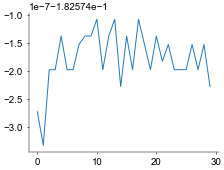

tensor(5.0832)
tensor(1.2574)


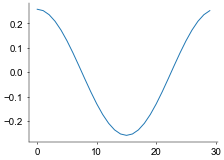

tensor(5.0832)
tensor(0.8239)


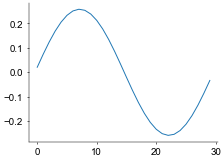

tensor(3.0529)
tensor(-0.5905)


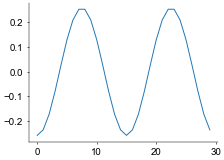

tensor(3.0529)
tensor(0.9553)


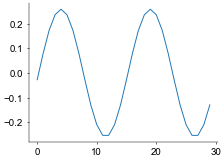

tensor(-0.4748)
tensor(4.7684e-07)


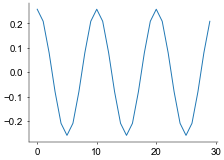

tensor(-0.4748)
tensor(-0.7619)


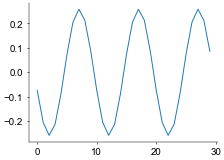

tensor(0.1684)
tensor(-7.1526e-07)


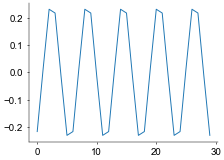

tensor(0.1684)
tensor(5.3644e-07)


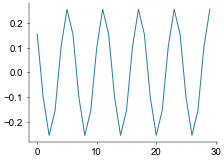

tensor(-0.1075)
tensor(0.2044)


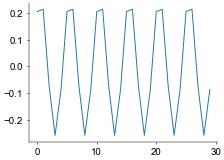

tensor(-0.1075)
tensor(0.1758)


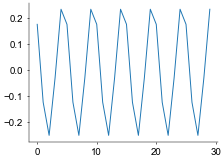

tensor(0.0640)
tensor(-0.1872)


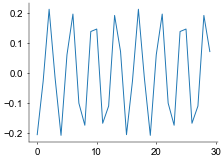

tensor(0.0640)
tensor(0.1395)


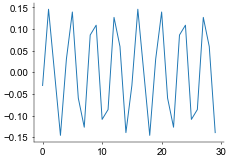

tensor(0.0378)
tensor(0.0496)


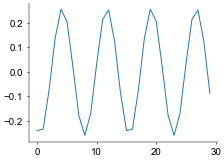

tensor(0.0378)
tensor(-0.3065)


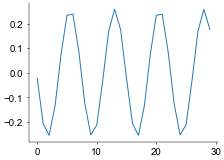

tensor(0.0269)
tensor(0.1488)


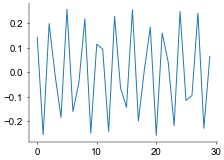

tensor(0.0269)
tensor(-0.1077)


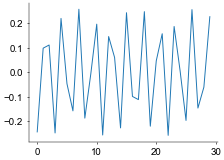

tensor(-0.0324)
tensor(-0.0503)


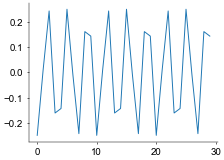

tensor(-0.0324)
tensor(-0.0810)


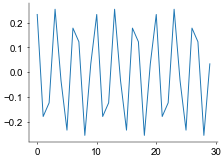

tensor(0.0071)
tensor(0.0932)


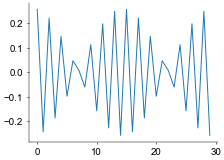

tensor(0.0071)
tensor(0.1275)


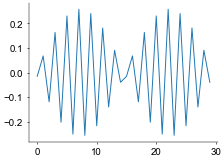

tensor(-0.0044)
tensor(7.3612e-06)


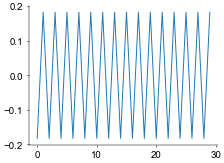

tensor(-0.0059)
tensor(0.2494)


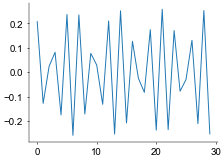

tensor(-0.0059)
tensor(0.1845)


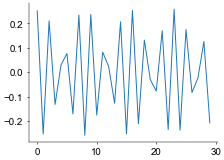

tensor(-0.0100)
tensor(-0.2582)


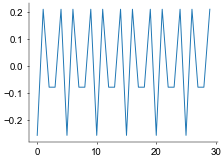

tensor(-0.0148)
tensor(-0.2791)


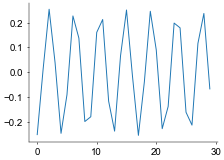

tensor(-0.0148)
tensor(0.0464)


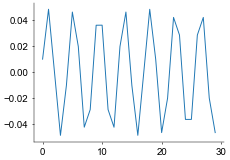

tensor(-0.0144)
tensor(3.6117e-05)


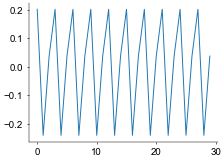

tensor(-0.0144)
tensor(-7.6130e-05)


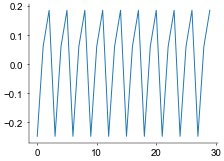

tensor(-0.0100)
tensor(0.2550)


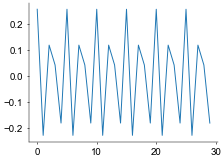

In [405]:
n_e = 0
v = torch.ones(Tl)
v[6:] = 0
L, V = torch.eig(K[0, ...], eigenvectors=True)
for n_e in range(Tl):
    print(L[n_e][0])
    print((V[:, n_e]*v).sum())
    plt.plot(V[:, n_e].numpy())
    #plt.ylim(0)
    plt.show()

In [332]:
v = torch.randn(1, 2, K.shape[-1])
v[..., 5:] = 0.
r = (Km()[:, None, ...] * v[..., None, :]).sum(-1)
r_ = Km.mvm(r)
r__ = Kmc.mvm(v, p=0.5)
r___ = Kmc.mvm(r__, p=0.5)

In [333]:
r__[..., :5]

tensor([[[-0.2414, -0.5968, -0.4174,  0.2291,  0.4338],
         [ 0.1073, -0.1103, -0.3311, -0.9786, -1.1669]]])

In [327]:
print(((r-r___)**2).sum())

tensor(8.7325e-13)


In [174]:
r.sum()

tensor(-2.4660e+08)

In [372]:
a = torch.zeros(Tl)
a[:10] = torch.randn(Tl)
plt.plot(np.real(torch.fft.rfft(a).numpy()))
plt.plot(np.imag(torch.fft.rfft(a).numpy()))

RuntimeError: The expanded size of the tensor (6) must match the existing size (16) at non-singleton dimension 0.  Target sizes: [6].  Tensor sizes: [16]

In [251]:
print(((v-r___)**2).sum())

tensor(29655.7589, dtype=torch.float64)


In [252]:
print(((v-r_)**2).sum())

tensor(596514.7119, dtype=torch.float64)


In [377]:
Tl = 100
sample_bin = 0.001

dn = 1

l = 2*sample_bin*np.ones((dn, 1))
v = np.ones(dn)

kernel_tuples = [('variance', v), 
                 ('RBF', 'euclid', l)]


kernel, _, _ = GP.kernels.create_kernel(kernel_tuples, 'softplus', torch.float)

T = torch.arange(Tl)*sample_bin
inp = T[None, None, :, None]
K = kernel(inp, inp)[0]
K.view(-1)[::Tl**2+1] += 0

UBk = 1#K.sum(-1).max(-1)[0]
    
Km = GP.linalg.general_matrix(K/UBk, ())

In [378]:
eigs = torch.eig(Km.explicit()[0, ...])[0][:, 0]
kappa = eigs.max()/eigs.min()
print(kappa)
print(eigs.max())
print(eigs.min())

tensor(-297744.4375, grad_fn=<DivBackward0>)
tensor(5.0038, grad_fn=<MaxBackward1>)
tensor(-1.6806e-05, grad_fn=<MinBackward1>)


In [385]:
L = torch.tril(Km.explicit()[0, ...], diagonal=-1)
D = torch.zeros((100, 100))
D[range(100), range(100)] = 1



omega = 1.9
SSOR = omega/(2-omega) * (D/omega + L) @ D @ (D/omega + L.T)

In [386]:
M = SSOR.inverse() @ Km.explicit()[0, ...]

eigs = torch.eig(M)[0][:, 0]
kappa = eigs.max()/eigs.min()
print(kappa)
print(eigs.max())
print(eigs.min())

tensor(-4136.6260, grad_fn=<DivBackward0>)
tensor(1.0000, grad_fn=<MaxBackward1>)
tensor(-0.0002, grad_fn=<MinBackward1>)


In [213]:
eps = torch.randn(10000, Tl)
with torch.no_grad():
    eps_ = Km.mvm(eps)
    
    
# rejection sampling    
log_pa = -0.5*((eps_*eps_).sum(-1) - (eps*eps).sum(-1))
log_pa -= log_pa.max()

acc = torch.bernoulli(torch.exp(log_pa))

In [214]:
log_pa.min()

tensor(-10.9807)

In [200]:
f = lambda x: np.log(1-x)
cheb_n = 1000
mc = 1000

with torch.no_grad():
    UB = Km.explicit().sum(-1).max() #full_vector().sum(-1) # Toeplitz primary vector
    logdet = GP.linalg.log_det_Chebyshev(Km, UB, mc, f, cheb_n, recursive=True)

In [201]:
log_w = -0.5*((eps_*eps_).sum(-1) - (eps*eps).sum(-1)) + logdet

lm = log_w.max()

qK = (eps * Km.mvm(eps_)).sum(-1)
res = torch.exp(lm) * ( torch.exp(log_w-lm) * qK ).mean(0)

In [202]:
res

tensor(1.6272, grad_fn=<MulBackward0>)

In [203]:
(eps*eps).sum(-1).mean(0)

tensor(5.0062)

In [99]:
qK.shape

torch.Size([1000])

In [68]:
L = torch.cholesky(K)
logdet_chol = 2*torch.log(L[..., np.arange(K.shape[-1]), np.arange(K.shape[-1])]).sum(-1)

print(torch.slogdet(K)[1])
print(logdet_chol)

tensor([-10.2743], grad_fn=<SlogdetBackward>)
tensor([-10.2744], grad_fn=<MulBackward0>)


In [48]:
logdet_chol.backward()

In [51]:
list(kernel.parameters())[0].grad

tensor([4.7438])

In [317]:
B = torch.randn(1, 1, Tl)
Km.tensor = Km.tensor.double()
B = B.double()

In [330]:
X_k = GP.linalg.linear_cg(Km.mvm, B)

CG terminated in 5000 iterations with average residual norm 1.2429861675664265e-06 which is larger than the tolerance of 1e-12 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.


In [334]:
UB = K.sum(-1).max(-1)[0]

X_kn = Neumann(Km, UB, B, n=1000)
print(X_kn)

tensor([[[  -5.4844,  -35.1152,  127.4936, -142.1654,   -8.3591,  176.6158,
          -143.7373,  -69.1143,  225.0925, -188.2023,   51.4914,   44.8072,
           -62.5786,   52.7404,  -63.8373,   70.5471,  -45.9209,   32.3242,
           -76.0690,  146.2642, -169.0760,  130.9046,  -78.3904,   38.5850,
           -13.0697,   -2.8886,   24.5330,  -34.3684,   -2.2584,   40.8205,
            -0.9026, -102.4571,  166.3929, -133.8413,   55.7714,  -24.3292,
            51.0791,  -33.3335,  -91.0863,  214.7423, -178.6866,    1.0623,
           123.5346,  -88.1807,   -5.3401,   11.4811,   84.5000, -179.6997,
           188.8154, -121.5848,   28.4071,   39.1471,  -50.3432,   12.1591,
            43.9970,  -83.2975,   45.1276,   90.2401, -220.6022,  228.4828,
          -140.8502,   83.5866, -103.1851,  112.9546,  -59.9773,   21.2048,
           -69.2939,  159.7532, -175.9011,   58.8071,  116.3398, -187.0064,
            92.8659,   44.0341,  -81.3872,   22.6915,   30.5482,  -38.3547,
            

In [327]:
X_k, cg_info = GP.linalg.cg_batch(Km.mvm, B, M_bmm=None, X0=None, rtol=1e-3, atol=0., maxiter=None, verbose=True, lr=1e-3, resetiter=10)

 it |       dist   it/s
001 | 5.3629e+01 916.61
002 | 5.3602e+01 1950.59
003 | 5.3584e+01 2139.07
004 | 5.3571e+01 2127.88
005 | 5.3560e+01 2200.08
006 | 5.3551e+01 2318.94
007 | 5.3543e+01 2239.39
008 | 5.3537e+01 2218.21
009 | 5.3531e+01 2268.87
010 | 5.3525e+01 2322.34
011 | 5.3472e+01 1985.07
012 | 5.3445e+01 1592.51
013 | 5.3427e+01 2195.97
014 | 5.3414e+01 1778.87
015 | 5.3403e+01 2242.61
016 | 5.3394e+01 2280.36
017 | 5.3386e+01 2324.47
018 | 5.3380e+01 2308.70
019 | 5.3374e+01 2301.60
020 | 5.3368e+01 2358.00
021 | 5.3315e+01 1972.36
022 | 5.3288e+01 2225.44
023 | 5.3271e+01 2274.55
024 | 5.3257e+01 2308.40
025 | 5.3247e+01 2288.66
026 | 5.3238e+01 2308.69
027 | 5.3230e+01 2274.86
028 | 5.3223e+01 2310.35
029 | 5.3218e+01 2345.61
030 | 5.3212e+01 2314.08
031 | 5.3159e+01 2003.32
032 | 5.3132e+01 2299.06
033 | 5.3115e+01 2315.47
034 | 5.3101e+01 2318.46
035 | 5.3091e+01 2333.80
036 | 5.3082e+01 2329.35
037 | 5.3074e+01 2323.87
038 | 5.3068e+01 2258.45
039 | 5.3062e+01 2279.16
04

In [332]:
X_k_ = (Km().inverse()[..., None, :, :] * B[..., None, :]).sum(-1)
print(X_k_)

tensor([[[ 3.1548e+03, -1.9690e+04,  6.3036e+04, -1.4237e+05,  2.5811e+05,
          -4.0161e+05,  5.5743e+05, -7.0705e+05,  8.3341e+05, -9.2497e+05,
           9.7694e+05, -9.8908e+05,  9.6196e+05, -8.9487e+05,  7.8707e+05,
          -6.4155e+05,  4.6836e+05, -2.8494e+05,  1.1281e+05,  2.7756e+04,
          -1.2278e+05,  1.6764e+05, -1.6760e+05,  1.3553e+05, -8.7495e+04,
           3.7912e+04,  3.8622e+03, -3.4422e+04,  5.4840e+04, -6.7924e+04,
           7.5405e+04, -7.6467e+04,  6.8353e+04, -4.8554e+04,  1.7127e+04,
           2.2134e+04, -6.2185e+04,  9.4557e+04, -1.1185e+05,  1.1012e+05,
          -9.0294e+04,  5.7804e+04, -2.0724e+04, -1.2803e+04,  3.6523e+04,
          -4.6923e+04,  4.3572e+04, -2.9475e+04,  1.1137e+04,  2.5907e+03,
          -3.2385e+03, -1.3849e+04,  4.6959e+04, -8.7778e+04,  1.2380e+05,
          -1.4255e+05,  1.3620e+05, -1.0522e+05,  5.9400e+04, -1.5030e+04,
          -1.1443e+04,  1.0418e+04,  1.6650e+04, -5.7666e+04,  9.4383e+04,
          -1.0908e+05,  9

In [335]:
torch.abs(X_k_ - X_kn)

tensor([[[3.1603e+03, 1.9655e+04, 6.2909e+04, 1.4223e+05, 2.5812e+05,
          4.0178e+05, 5.5758e+05, 7.0698e+05, 8.3319e+05, 9.2478e+05,
          9.7689e+05, 9.8912e+05, 9.6203e+05, 8.9492e+05, 7.8713e+05,
          6.4162e+05, 4.6840e+05, 2.8497e+05, 1.1289e+05, 2.7609e+04,
          1.2261e+05, 1.6751e+05, 1.6753e+05, 1.3550e+05, 8.7482e+04,
          3.7914e+04, 3.8377e+03, 3.4387e+04, 5.4843e+04, 6.7964e+04,
          7.5406e+04, 7.6365e+04, 6.8187e+04, 4.8420e+04, 1.7071e+04,
          2.2158e+04, 6.2236e+04, 9.4590e+04, 1.1176e+05, 1.0991e+05,
          9.0116e+04, 5.7803e+04, 2.0847e+04, 1.2715e+04, 3.6528e+04,
          4.6934e+04, 4.3487e+04, 2.9296e+04, 1.0948e+04, 2.7123e+03,
          3.2669e+03, 1.3888e+04, 4.7009e+04, 8.7790e+04, 1.2376e+05,
          1.4246e+05, 1.3615e+05, 1.0531e+05, 5.9621e+04, 1.5258e+04,
          1.1302e+04, 1.0334e+04, 1.6753e+04, 5.7779e+04, 9.4443e+04,
          1.0910e+05, 9.1214e+04, 4.1465e+04, 2.8044e+04, 9.7917e+04,
          1.4826e+05

In [88]:
n = 100
f = lambda x: 1/(1-x)

c = GP.chebyshev.Chebyshev_coeff(f, n)

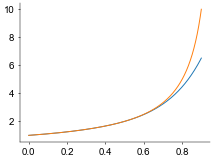

In [90]:
x = np.linspace(0.0, 0.9, 1000)

k = np.arange(0, 10)
yy = (x[:, None]**k[None, :]).sum(-1)

y = GP.chebyshev.eval_Chebyshev(x, c)
plt.plot(x, yy)
plt.plot(x, f(x))
plt.show()

In [313]:
data = np.abs(Km().inverse()[0, ...].numpy())

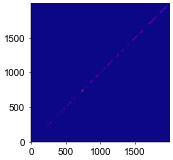

In [314]:
fig, ax = plt.subplots()


im = utils.plot.draw_2d((fig, ax), data, origin='lower', cmap='plasma', vmin=0, vmax=data.max(), aspect='equal')

### TT algebra

In [112]:
batch_shape = (2,)
dim_list = [10]
GR_K = 3
mc = 2

random_G = GP.linalg.sample_Gauss_Rademacher(batch_shape, mc, dim_list, GR_K)

In [113]:
random_G.tensor_list[0]().shape

torch.Size([2, 2, 3, 10])

In [114]:
random_G.trace_i()

tensor([[[ 0.1686,  0.4185, -0.2104,  0.8929,  1.5443,  1.3515,  0.7762,
           1.5989, -0.1184, -1.5548],
         [ 1.3935, -0.5687,  0.8508, -0.3485, -0.2671, -0.7982,  0.7285,
           1.2073,  1.3788, -0.6392]],

        [[ 0.8995,  2.6155,  1.3558,  1.5800, -0.2458,  0.1168, -1.0426,
           1.2135,  1.0616, -1.5230],
         [ 0.0230,  0.1509,  0.9078, -0.0774, -0.9707,  2.4064,  0.0312,
           0.8023, -0.6235,  0.1953]]])

In [115]:
Psi_list = [torch.randn(mc, *batch_shape, 1, dim_list[d]) for d in range(len(dim_list))]
Psi = GP.linalg.TT_vector([GP.linalg.vector(v, (-1,)) for v in Psi_list], 1)

In [116]:
Psi.tensor_list[0]().shape

torch.Size([2, 2, 1, 10])

In [117]:
G = Psi.hadamard_prod(random_G)

In [118]:
G.explicit()

tensor([[[ 0.0942,  0.7279, -0.2490,  1.6154, -2.1319,  0.2715, -0.6625,
          -0.8536, -0.1596, -0.2210],
         [-1.4364, -0.2803,  0.6118,  0.1786,  0.2803,  0.0326, -0.7847,
           1.1806, -0.5361,  0.3398]],

        [[ 1.1520,  0.3872, -0.0137,  0.8303,  0.3593, -0.2124,  0.7760,
          -1.7435,  0.7430, -0.4006],
         [ 0.0109, -0.0558, -0.5135,  0.0254, -0.0193, -1.1249, -0.0399,
          -0.2680, -0.1922,  0.0315]]])

In [119]:
Psi.explicit()*random_G.explicit()

tensor([[[ 0.0942,  0.7279, -0.2490,  1.6154, -2.1319,  0.2715, -0.6625,
          -0.8536, -0.1596, -0.2210],
         [-1.4364, -0.2803,  0.6118,  0.1786,  0.2803,  0.0326, -0.7847,
           1.1806, -0.5361,  0.3398]],

        [[ 1.1520,  0.3872, -0.0137,  0.8303,  0.3593, -0.2124,  0.7760,
          -1.7435,  0.7430, -0.4006],
         [ 0.0109, -0.0558, -0.5135,  0.0254, -0.0193, -1.1249, -0.0399,
          -0.2680, -0.1922,  0.0315]]])

In [129]:
tl = [torch.randn(mc, *batch_shape, 1, dim_list[d]-1) for d in range(len(dim_list))]

tIm = GP.linalg.TT_matrix([GP.linalg.trilI_Toeplitz_matrix(m, (-1,)) for m in tl], 1, 1)

In [130]:
tIm.explicit()[0, 0, ...]

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-2.1967,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-1.1594, -2.1967,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 1.3493, -1.1594, -2.1967,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.4966,  1.3493, -1.1594, -2.1967,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.5829,  0.4966,  1.3493, -1.1594, -2.1967,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.3987, -0.5829,  0.4966,  1.3493, -1.1594, -2.1967,  1.0000,  0.0000,
          0.0000,  0.0000],
        [-1.2676,  0.3987, -0.5829,  0.4966,  1.3493, -1.1594, -2.1967,  1.0000,
          0.0000,  0.0000],
        [-0.7882, -1.2676,  0.3987, -0.5829,  0.4966,  1.3493, -1.1594, -2.1967,
          1.0000,  0.0000],
        [-1.3494, -

In [11]:
ttk.explicit().shape

torch.Size([1, 1, 9, 9])

In [7]:
Tl = 3
sample_bin = 0.001

dn = 1

l = 2.*sample_bin*np.ones((dn, 1))
l_2 = 4.*sample_bin*np.ones((dn, 1))
v = np.ones(dn)

In [10]:

K_list = [GP.kernels.Product(
    GP.kernels.Constant(variance=torch.tensor(v, dtype=torch.float)), 
    GP.kernels.RBF(input_dims=len(l), \
                   lengthscale=torch.tensor(l, dtype=torch.float), \
                   topology='euclid')), 
    GP.kernels.RBF(input_dims=len(l_2), \
                   lengthscale=torch.tensor(l_2, dtype=torch.float), \
                   topology='euclid')
]
track_dims_list = [[0], [1]]

TTk = GP.kernels.KTT_kernel(K_list, track_dims_list)


U_list = [torch.arange(Tl)[None, None, :, None]*sample_bin, 
          torch.arange(Tl)[None, None, :, None]*sample_bin]

ttk = TTk.Kronecker_Toeplitz(U_list)

In [ ]:
f = lambda x: np.log(1-x)
cheb_n = 1000
mc = 10
D = len(ttk.tensor_list)

d_list = np.empty((D,))
for en, tt_ in enumerate(ttk.tensor_list):
    d_list[en] = tt_.n

logdets = []
d_vec = []
for en, tt_ in enumerate(ttk.tensor_list):
    UB = tt_.full_vector().sum(-1) # Toeplitz primary vector
    logdet = GP.linalg.log_det_Chebyshev(tt_, UB, mc, f, cheb_n, recursive=True)
    d_others = np.prod(d_list[np.arange(D) != en])
    logdets.append(d_others*logdet)



In [297]:
torch.stack(logdets).sum(0)

tensor([[[-84.9136]]], grad_fn=<SumBackward1>)

In [202]:
TTk(torch.cat(U_list, dim=-1)).tensor_list[0]()-TTk.X_U_list(torch.cat(U_list, dim=-1), U_list).tensor_list[0]()

tensor([[[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]]],
       grad_fn=<SubBackward0>)

In [78]:
V_list = [GP.linalg.vector(torch.randn(2, Tl)[None, None, ...]*sample_bin, (-1,)), 
          GP.linalg.vector(torch.randn(2, Tl)[None, None, ...]*sample_bin, (-1,))]

ttv = GP.linalg.TT_vector(V_list, 1)

ttv_ = ttk.mvm(ttv)

In [79]:
print(ttv.scalar_prod(ttv_))
print((ttv.explicit()[..., None] * ttk.explicit() * ttv.explicit()[..., None, :]).sum(-1).sum(-1))

tensor([[1.7098e-11]], grad_fn=<SumBackward1>)
tensor([[1.7098e-11]], grad_fn=<SumBackward1>)


In [74]:
ttv.trace_i()

tensor([[8.5963e-12]], grad_fn=<SumBackward1>)

In [374]:
kernel_tuples = [('variance', v), 
                 ('RBF', 'euclid', l), 
                 ('RBF', 'euclid', l_2)]

with torch.no_grad():
    kernel, _, _ = GP.kernels.create_kernel(kernel_tuples, 'softplus', torch.float)

    T = torch.arange(Tl)*sample_bin
    T_2 = torch.arange(Tl)*sample_bin
    grid_1, grid_2 = torch.meshgrid(T, T_2)
    inp = torch.cat((grid_1.flatten()[None, None, :, None], grid_2.flatten()[None, None, :, None]), dim=-1)
    K = kernel(inp, inp)[0, 0]
    K.view(-1)[::Tl**2+1] += 1e-12
    
    
    # Nystrom
    U = torch.arange(Tl)*sample_bin
    grid_1, grid_2 = torch.meshgrid(U, U)
    inp_U = torch.cat((grid_1.flatten()[None, None, :, None], grid_2.flatten()[None, None, :, None]), dim=-1)
    K_1 = kernel(inp, inp_U)[0, 0]
    K_2 = kernel(inp_U, inp)[0, 0]
    K_U = kernel(inp_U, inp_U)[0, 0]
    K_U.view(-1)[::Tl**2+1] += 1e-12

In [378]:
L = torch.cholesky(K[None, None, ...])
logdet_chol = 2*torch.log(L[..., np.arange(K.shape[0]), np.arange(K.shape[0])]).sum(-1)

print(torch.slogdet(K)[1])
print(logdet_chol)

tensor(-35.0937)
tensor([[-35.0935]])


In [377]:
L.shape

torch.Size([1, 1, 9, 9])

In [361]:
((K-K_nys)**2).sum()

tensor(31386784.)

### GPFADS

# GPFA

In [ ]:
import numpy as np
from scipy import stats
#from sklearn.linear_model import LinearRegression()
#model = LinearRegression().fit(n_1, n_2)

a = 0.8
n_1 = []
n_2 = []
for y_1 in np.linspace(80.0, 100.0, 50):
    y_2 = a*y_1
    n_1.append(np.random.poisson(y_1, size=(100,)))
    n_2.append(np.random.poisson(y_2, size=(100,)))
    
n_1 = np.asarray(n_1).reshape(-1)
n_2 = np.asarray(n_2).reshape(-1)

plt.scatter(n_1, n_2, s=1)
x = np.array([60.0, 120.0])
plt.plot(x, a*x, label='truth', c='c')
slope, intercept, r_value, p_value, std_err = stats.linregress(n_1,n_2)
plt.plot(x, x*slope + intercept, 'r--', label='regression')
plt.xlabel(r'$n_1$')
plt.ylabel(r'$n_2$')
plt.legend()
plt.show()

plt.scatter(np.sqrt(n_1), np.sqrt(n_2), s=1)
x = np.array([8.0, 11.0])
plt.plot(x, np.sqrt(a)*x, label='truth', c='c')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.sqrt(n_1),np.sqrt(n_2))
plt.plot(x, x*slope + intercept, 'r--', label='regression')
plt.xlabel(r'$\sqrt{n_1}$')
plt.ylabel(r'$\sqrt{n_2}$')
plt.legend()
plt.show()


from sklearn.decomposition import PCA
d_1 = n_1
d_2 = n_2

X = np.stack([d_1-d_1.mean(), d_2-d_2.mean()]).T
pca = PCA(n_components=2)
pca.fit(X)
V = pca.components_
print(V.shape)
x_pca_axis, y_pca_axis = 2 * V.T
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

plt.scatter(d_1, d_2, s=1)
x = np.array([60.0, 120.0])
plt.plot(x, a*x, label='truth', c='c')
slope = y_pca_axis[0]/x_pca_axis[0]
dx = 30.0
x = [d_1.mean() - dx, d_1.mean() + dx]
y = [d_2.mean() - dx*slope, d_2.mean() + dx*slope]
plt.plot(x, y, 'r--', label='PCA')
plt.xlabel(r'$n_1$')
plt.ylabel(r'$n_2$')
plt.legend()
plt.show()


d_1 = np.sqrt(n_1)
d_2 = np.sqrt(n_2)

X = np.stack([d_1-d_1.mean(), d_2-d_2.mean()]).T
pca = PCA(n_components=2)
pca.fit(X)
V = pca.components_
print(V.shape)
x_pca_axis, y_pca_axis = 2 * V.T
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

plt.scatter(d_1, d_2, s=1)
x = np.array([8.0, 11.0])
plt.plot(x, np.sqrt(a)*x, label='truth', c='c')
slope = y_pca_axis[0]/x_pca_axis[0]
dx = 1.5
x = [d_1.mean() - dx, d_1.mean() + dx]
y = [d_2.mean() - dx*slope, d_2.mean() + dx*slope]
plt.plot(x, y, 'r--', label='PCA')
plt.xlabel(r'$\sqrt{n_1}$')
plt.ylabel(r'$\sqrt{n_2}$')
plt.legend()
plt.show()

In [ ]:
x = np.linspace(0, 10, 50)
y = 0.3*x

plt.scatter(x, y)
plt.show()

x_ = np.tile(x, (10))
x_n = x_ + np.random.randn(len(x)*10)*0.0
y_ = 0.3*x_n  + np.random.randn(len(x)*10)*0.1

plt.scatter(x_, y_, s=1)
plt.show()

In [ ]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 20
num_spiketrains = 50

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

In [ ]:
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [ ]:
from elephant.gpfa import GPFA


# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

gpfa_2dim.fit(spiketrains_oscillator[:num_trials//2])
print(gpfa_2dim.params_estimated.keys())

trajectories = gpfa_2dim.transform(spiketrains_oscillator[num_trials//2:])

# visualize trajectories
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
ax1.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

# here we just reuse the existing instance of the GPFA() class as we use the same fitting parameters as before
trajectories_all = gpfa_2dim.fit_transform(spiketrains_oscillator)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Latent dynamics extracted by GPFA')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
for single_trial_trajectory in trajectories_all:
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
average_trajectory = np.mean(trajectories_all, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.legend()

trial_to_plot = 0
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories_all[trial_to_plot][0])) * bin_size.rescale('s')
ax2.plot(times_trajectory, trajectories_all[0][0], c='C0', label="Dim 1, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][0], c='C0', alpha=0.2, label="Dim 1, fitting with a half of trials")
ax2.plot(times_trajectory, trajectories_all[0][1], c='C1', label="Dim 2, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][1], c='C1', alpha=0.2, label="Dim 2, fitting with a half of trials")
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# set parameters for the integration of the Lorentz attractor
timestep = 1 * pq.ms
transient_duration = 10 * pq.s
trial_duration = 30 * pq.s
num_steps_transient = int((transient_duration.rescale('ms')/timestep).magnitude)
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data
num_trials = 20
num_spiketrains = 50

# calculate the oscillator
times, lorentz_trajectory_3dim = integrated_lorenz(
    timestep, num_steps=num_steps_transient+num_steps, x0=0, y0=1, z0=1.25)
times = (times - transient_duration).rescale('s').magnitude
times_trial = times[num_steps_transient:]

# random projection
lorentz_trajectory_Ndim = random_projection(
    lorentz_trajectory_3dim[:, num_steps_transient:], embedding_dimension=num_spiketrains)

# calculate instantaneous rate
normed_traj = lorentz_trajectory_Ndim / lorentz_trajectory_Ndim.max()
instantaneous_rates_lorentz = np.power(max_rate.magnitude, normed_traj)

# generate spiketrains
spiketrains_lorentz = generate_spiketrains(
    instantaneous_rates_lorentz, num_trials, timestep)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2, projection='3d')
ax3 = f.add_subplot(2, 2, 3)
ax4 = f.add_subplot(2, 2, 4)

ax1.set_title('Lorentz system')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim):
    ax1.plot(times, x, label=labels[i])
ax1.axvspan(-transient_duration.rescale('s').magnitude, 0, color='gray', alpha=0.1)
ax1.text(-5, -20, 'Initial transient', ha='center')
ax1.legend()

ax2.set_title(f'Trajectory in 3-dim space')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_ylabel('z')
ax2.plot(lorentz_trajectory_3dim[0, :num_steps_transient],
         lorentz_trajectory_3dim[1, :num_steps_transient],
         lorentz_trajectory_3dim[2, :num_steps_transient], c='C0', alpha=0.3)
ax2.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:], c='C0')

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('Time [s]')
y_offset = lorentz_trajectory_Ndim.std() * 3
for i, y in enumerate(lorentz_trajectory_Ndim):
    ax3.plot(times_trial, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Neuron id')
for i, spiketrain in enumerate(spiketrains_lorentz[trial_to_plot]):
    ax4.plot(spiketrain, np.ones(len(spiketrain)) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [77]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 3

gpfa_3dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
trajectories = gpfa_3dim.fit_transform(spiketrains_lorentz)

# visualize
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax2 = f.add_subplot(1, 2, 2, projection='3d')

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2],
             lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], average_trajectory[2], lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()
ax2.view_init(azim=-5, elev=60)  # an optimal viewing angle for the trajectory extracted from our fixed spike trains

plt.tight_layout()
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim[:, num_steps_transient:]):
    ax1.plot(times_trial, x, label=labels[i])
ax1.legend()

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Time [s]')
for i, x in enumerate(average_trajectory):
    ax2.plot(np.arange(len(x))*0.02, x, label=f'Dim {i+1}')
ax2.legend()

plt.tight_layout()
plt.show()

NameError: name 'pq' is not defined

In [ ]:
# Cross validation to deduce most likely dimensionality
from sklearn.model_selection import cross_val_score

x_dims = [1, 2, 3, 4, 5]
log_likelihoods = []
for x_dim in x_dims:
    gpfa_cv = GPFA(x_dim=x_dim)
    # estimate the log-likelihood for the given dimensionality as the mean log-likelihood of 3-fold cross-validation
    cv_log_likelihoods = cross_val_score(gpfa_cv, spiketrains_lorentz, cv=3, n_jobs=3, verbose=True)
    log_likelihoods.append(np.mean(cv_log_likelihoods))
    
f = plt.figure(figsize=(7, 5))
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.tight_layout()
plt.show()

In [3]:
left_x = 0.0
right_x = 538.4177999999999
bottom_y = 0.0
top_y = 432.3225
arena_width = right_x - left_x
arena_height = top_y - bottom_y



def generate_data(mode, track_samples=3000000):
    neurons = 1
    sample_bin = 1./1250
    
    # Mixture of Gaussians
    if mode == 'pos':
        t_p = np.array([[0.0, 0.0]])
        hd_p = np.array([[0.0, 0.0]])
        dir_p = np.array([[0.0, 0.0]])
        sp = np.array([0.0])
    elif mode == 'pos_theta':
        t_p = np.array([[1.0, 0.2]]) # beta, phi_0 for theta modulation
        hd_p = np.array([[0.0, 0.0]])
        dir_p = np.array([[0.0, 0.0]])
        sp = np.array([0.0])
    elif mode == 'pos_theta_hd':
        t_p = np.array([[1.0, 0.2]]) # beta, phi_0 for theta modulation
        hd_p = np.array([[0.5, 2.0]])
        dir_p = np.array([[0.0, 0.0]])
        sp = np.array([0.0])
    elif mode == 'pos_speed_theta_hd':
        t_p = np.array([[1.0, 0.2]]) # beta, phi_0 for theta modulation
        hd_p = np.array([[0.5, 2.0]])
        dir_p = np.array([[0.0, 0.0]])
        sp = np.array([0.001])
        
    mu = np.array([[100., 100.]])
    prec = np.array([[0.0002, 0.0002, 0.0]])
    rate_0 = np.array([10.0]) # Hz
    
    gauss_1 = mdl.parametrics.PTP_field(neurons, 'exp')
    gauss_1.set_params(sample_bin, mu, prec, rate_0, t_p, hd_p, dir_p, sp)

    mu = np.array([[170., 350.]])
    prec = np.array([[0.0002, 0.0002, 0.0]])
    rate_0 = np.array([10.0]) # Hz

    gauss_2 = mdl.parametrics.PTP_field(neurons, 'exp')
    gauss_2.set_params(sample_bin, mu, prec, rate_0, t_p, hd_p, dir_p, sp)

    mu = np.array([[400., 225.]])
    prec = np.array([[0.0003, 0.0001, 0.0]])
    rate_0 = np.array([10.0]) # Hz
    
    gauss_3 = mdl.parametrics.PTP_field(neurons, 'exp')
    gauss_3.set_params(sample_bin, mu, prec, rate_0, t_p, hd_p, dir_p, sp)

    gauss_rate = mdl.parametrics.mixture_model([gauss_1, gauss_2, gauss_3])
    gauss_rate.set_params(sample_bin)
    
    # sample behaviour
    print('Generating animal behaviour...')
    tc = 30.
    arena = [('wall', (np.array([right_x+tc, bottom_y-tc]), 
                       np.array([left_x-tc, bottom_y-tc]), tc)), 
             ('wall', (np.array([left_x-tc, bottom_y-tc]), 
                       np.array([left_x-tc, top_y+tc]), tc)), 
             ('wall', (np.array([left_x-tc, top_y+tc]), 
                       np.array([right_x+tc, top_y+tc]), tc)), 
             ('wall', (np.array([right_x+tc, top_y+tc]), 
                       np.array([right_x+tc, bottom_y-tc]), tc))]
    an = animal.animal_SL(sample_bin, track_samples, arena)

    sample_bin, sim_samples, x_t, y_t, \
        s_t, dir_t, hd_t, theta_t = \
        an.sample(0.01, [200.0, 200.0], 200, 0.14, 0.0)

    wrap_theta_t = tools.WrapPi(theta_t, True)
    maxspeed = s_t.max()
    
    behav_data = [x_t, y_t, s_t, wrap_theta_t, hd_t, dir_t]
    
    # add true field
    unit = 0
    if mode == 'pos':
        grid_size = [int(arena_width/10), int(arena_height/10)]
        grid_shape = [[left_x, right_x], [bottom_y, top_y]]

        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            s = np.zeros_like(x)
            th = np.zeros_like(x)
            hd = np.zeros_like(x)
            dr = np.zeros_like(x)
            covariates = [x, y, s, th, hd, dr]
            return gauss_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'pos_theta':
        grid_size = (int(arena_width/10), int(arena_height/10), 30)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            s = np.zeros_like(x)
            th = pos[2].flatten()
            hd = np.zeros_like(x)
            dr = np.zeros_like(x)
            covariates = [x, y, s, th, hd, dr]
            return gauss_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'pos_theta_hd':
        grid_size = (int(arena_width/20), int(arena_height/20), 10, 10)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0., 2*np.pi], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            s = np.zeros_like(x)
            th = pos[2].flatten()
            hd = pos[3].flatten()
            dr = np.zeros_like(x)
            covariates = [x, y, s, th, hd, dr]
            return gauss_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'pos_speed_theta_hd':
        grid_size = (int(arena_width/20), int(arena_height/20), 10, 10, 10)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0, maxspeed], [0., 2*np.pi], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            s = pos[2].flatten()
            th = pos[3].flatten()
            hd = pos[4].flatten()
            dr = np.zeros_like(x)
            covariates = [x, y, s, th, hd, dr]
            return gauss_rate.eval_rate(covariates, unit).reshape(*prevshape)

    print('Computing true field...')
    true_field = tools.compute_mesh(grid_size, grid_shape, func)[1]
    #_, ax = tools.visualize_field(true_field, grid_shape, ticktitle='')
    #plt.show()
    
    # sample spikes
    #shape = np.ones(neurons)
    #renewal_dist = mdl.likelihoods.Gamma(neurons, 'exp', shape)
    renewal_dist = mdl.likelihoods.Poisson(neurons, 'exp')
    renewal_dist.set_params(sample_bin)
    
    glm = mdl.inference.nll_optimized([gauss_rate], renewal_dist)
    glm.to(dev)
    
    print('Sampling spike trains...')
    ini_train = np.zeros((1, 1, 1)) # for trials
    rc_t, _, _ = glm.sample(behav_data, ini_train)
    
    return true_field, behav_data, rc_t[0], sample_bin, maxspeed


In [4]:
# setup GP parameters
def GP_params(mode, behav_tuple, num_induc, maxspeed):
    units_ = 1
    l = np.ones(units_)
    v = np.ones(units_)

    if mode == 'pos':
        ind_list = [np.linspace(left_x, right_x, num_induc), \
                    bottom_y + arena_height*np.random.rand(num_induc)]

        kt = [('RBF', 'euclid', np.array([l, l]), v)]
        covariates = (behav_tuple[0], behav_tuple[1])

    elif mode == 'pos_theta':
        ind_list = [np.linspace(left_x, right_x, num_induc), \
                    bottom_y + arena_height*np.random.rand(num_induc), \
                    np.random.rand(num_induc)*2*np.pi]

        kt = [('RBF', 'euclid', np.array([l, l]), v), ('RBF', 'torus', np.array([l]), v)]
        covariates = (behav_tuple[0], behav_tuple[1], behav_tuple[3])

    elif mode == 'pos_theta_hd':
        ind_list = [np.linspace(left_x, right_x, num_induc), \
                    bottom_y + arena_height*np.random.rand(num_induc), \
                    np.random.rand(num_induc)*2*np.pi, \
                    np.random.rand(num_induc)*2*np.pi]

        kt = [('RBF', 'euclid', np.array([l, l]), v), ('RBF', 'torus', np.array([l, l]), v)]
        covariates = (behav_tuple[0], behav_tuple[1], behav_tuple[3], behav_tuple[5])
        
    elif mode == 'pos_speed_theta_hd':
        ind_list = [np.linspace(left_x, right_x, num_induc), \
                    bottom_y + arena_height*np.random.rand(num_induc), \
                    np.random.rand(num_induc)*maxspeed, \
                    np.random.rand(num_induc)*2*np.pi, \
                    np.random.rand(num_induc)*2*np.pi]

        kt = [('RBF', 'euclid', np.array([l, l, l]), v), ('RBF', 'torus', np.array([l, l]), v)]
        covariates = (behav_tuple[0], behav_tuple[1], behav_tuple[2], behav_tuple[3], behav_tuple[5])

    else:
        ind_list = [np.linspace(left_x, right_x, num_induc), \
                    bottom_y + arena_height*np.random.rand(num_induc), \
                    np.random.rand(num_induc)*maxspeed, \
                    np.random.rand(num_induc)*2*np.pi, \
                    np.random.rand(num_induc)*2*np.pi, \
                    np.random.rand(num_induc)*2*np.pi]

        kt = [('RBF', 'euclid', np.array([l, l, l]), v), ('RBF', 'torus', np.array([l, l, l]), v)]
        covariates = behav_tuple
        
    return covariates, kt, ind_list, units_

In [3]:
# Synthetic data
sample_bin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
    syn_t_spike, spike_samples, neurons, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('./data/gauss_spat_IPP.p', 'rb'))

fac = 1000.

max_speed = s_t.max()/fac
wrap_theta_t = utils.signal.WrapPi(theta_t, True)

right_x = right_x/fac
left_x = left_x/fac
top_y = top_y/fac
bottom_y = bottom_y/fac

arena_width = right_x - left_x
arena_height = top_y - bottom_y
behav_data = [x_t/fac, y_t/fac]


bin_size = 20
tbin, resamples, rc_t, (rx_t, ry_t, rtheta_t) = \
    utils.neural.bin_data(bin_size, sample_bin, syn_t_spike, track_samples, 
                          (x_t, y_t, theta_t), average_behav=True, binned=False)


### Regression comparison
Comparing SVGP, inverse free SVGP, ...

In [4]:
gp_model = 'KCP'


# shared
VI_tuples = [(None, None, None, 1)]*3
l = 5.*np.ones((1, neurons))
l_ = 1.*np.ones((2, neurons))
v = np.ones(neurons)
    
ini_X = [
    rtheta_t, rx_t, ry_t
]
in_dims = 3
    

if gp_model == 'SVGP':
    
    kernels_tuples = [('variance', v), ('RBF', 'torus', l), ('RBF', 'euclid', l_)]

    num_induc = 32
    inducing_points = np.array([np.linspace(0, 2*np.pi, num_induc+1)[:-1], 
                                np.linspace(left_x, right_x, num_induc), 
                                np.linspace(bottom_y, top_y, num_induc)]).T[None, ...].repeat(neurons, axis=0)
    
    # mapping
    gp = mdl.nonparametrics.Gaussian_process(
        in_dims, neurons, kernels_tuples, inducing_points=inducing_points, 
        inv_link='exp', whiten=True, jitter=1e-4, mean=np.zeros(neurons), learn_mean=True
    )
    
    
elif gp_model == 'KCP':
    
    K_list = [GP.kernels.Product(
        GP.kernels.Constant(variance=torch.tensor(v, dtype=torch.float)), 
        GP.kernels.RBF(input_dims=1, \
                       lengthscale=torch.tensor(l, dtype=torch.float), \
                       topology='torus')), 
        GP.kernels.RBF(input_dims=1, \
                       lengthscale=torch.tensor(l_[:1, :], dtype=torch.float), \
                       topology='euclid'), 
        GP.kernels.RBF(input_dims=1, \
                       lengthscale=torch.tensor(l_[1:, :], dtype=torch.float), \
                       topology='euclid')
    ]
    
    track_dims_list = [[0], [1], [2]]
    kernel_TT = GP.kernels.KTT_kernel(K_list, track_dims_list)

    # inducing grid
    N_U = 100
    N_U_ = 32
    inducing_loc_list = [np.linspace(0, 2*np.pi, N_U_+1)[None, None, :-1, None],
                         np.linspace(left_x, right_x, N_U)[None, None, :, None], 
                         np.linspace(bottom_y, top_y, N_U)[None, None, :, None]]

    r_shape = (1,)
    nu_list = []
    Psi_list = []
    S_list = []
    S_type = []
    for u in inducing_loc_list:
        nu_list.append(np.zeros((neurons, *r_shape, u.shape[-2])))
        Psi_list.append(np.ones((neurons, u.shape[-2]))*1e-2)

        S_list.append(np.ones((neurons, u.shape[-2], u.shape[-2])))
        S_type.append(GP.linalg.general_matrix)
    #S_list = [np.zeros((neurons, u.shape[-2]-1))]*k_V
    #S_type = GP.linalg.trilI_Toeplitz_matrix


    # mapping
    gp = mdl.nonparametrics.KCP_SVGP(
        in_dims, neurons, kernel_TT, inducing_loc_list, nu_list, Psi_list, S_list, S_type, 
        cheb_n=100, cheb_mc=1, GR_K=1, tr_mc=10, logdet_cheb=[False]*in_dims, jitter=1e-4, 
        nu_rshape_len=1, inv_link='exp', mean=np.zeros(neurons), learn_mean=True
    )

In [8]:
batch_size = 5000


In [9]:
inputs = mdl.inference.input_group(in_dims, VI_tuples)
inputs.set_XZ(ini_X, resamples, batch_size=batch_size, filter_len=1)  


likelihood = mdl.likelihoods.Poisson(tbin, neurons, 'exp')


likelihood.set_Y(rc_t, batch_size=batch_size, filter_len=1) 

gp_model = mdl.inference.VI_optimized(inputs, gp, likelihood)
gp_model.to(dev)

VI_optimized(
  (inputs): input_group()
  (mapping): KCP_SVGP(
    (kernel): KTT_kernel(
      (K_list): ModuleList(
        (0): Product(
          (kern0): Constant()
          (kern1): RBF()
        )
        (1): RBF()
        (2): RBF()
      )
    )
    (nu_list): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x5x1x32 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 1x5x1x100 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 1x5x1x100 (GPU 0)]
    )
    (Psi_list): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x5x1x32 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 1x5x1x100 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 1x5x1x100 (GPU 0)]
    )
    (S_list): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x5x1x32x32 (GPU 0)]
        (1): Parameter containing: [torc

In [ ]:
start_iter = time.perf_counter()

end = time.perf_counter()

    if verbose:
        if optimal:
            print("Terminated in %d steps (reached maxiter). Took %.3f ms." %
                  (k, (end - start) * 1000))
        else:
            print("Terminated in %d steps (optimal). Took %.3f ms." %
                  (k, (end - start) * 1000))

In [10]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-2}

gp_model.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = gp_model.fit(3000, loss_margin=-1e0, margin_epochs=100, kl_anneal_func=annealing, 
                      cov_samples=1, ll_samples=10, ll_mode='MC')




RuntimeError: CUDA out of memory. Tried to allocate 288.00 MiB (GPU 0; 7.79 GiB total capacity; 2.96 GiB already allocated; 170.00 MiB free; 2.98 GiB reserved in total by PyTorch)

In [ ]:
# visualize fitting
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

In [ ]:
if losses[-1] < lowest_loss: # save model
    lowest_loss = losses[-1]

    model_name = 'bin{}_{}_{}_{}'.format(bin_size, datatype, ll_mode, kcv)
    torch.save({'glm': gp.state_dict()}, './checkpoint/' + model_name)

### Inducing points and expressivity, nonconvexity analysis

In [5]:
def compute_error(mode, glm_rate, true_field, unit=0):
    if mode == 'pos':
        grid_size = (int(arena_width/10), int(arena_height/10))
        grid_shape = [[left_x, right_x], [bottom_y, top_y]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            covariates = [x, y]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'pos_theta':
        grid_size = (int(arena_width/10), int(arena_height/10), 30)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            theta = pos[2].flatten()
            covariates = [x, y, theta]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'pos_theta_hd':
        grid_size = (int(arena_width/20), int(arena_height/20), 10, 10)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0., 2*np.pi], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            theta = pos[2].flatten()
            hd = pos[3].flatten()
            covariates = [x, y, theta, hd]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'pos_speed_theta_hd':
        grid_size = (int(arena_width/20), int(arena_height/20), 10, 10, 10)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0, maxspeed], [0., 2*np.pi], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            s = pos[2].flatten()
            theta = pos[3].flatten()
            hd = pos[4].flatten()
            covariates = [x, y, s, theta, hd]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'full':
        grid_size = (int(arena_width/10), int(arena_height/10), 30)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            theta = pos[2].flatten()
            covariates = [x, y, theta]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    return ((tools.compute_mesh(grid_size, grid_shape, func)[1]-true_field)**2).mean()

In [ ]:
# GP with variable regressors model fit and nonconvexity
num_induc_arr = [8, 16, 32, 64]
modes = ['pos', 'pos_theta', 'pos_theta_hd', 'pos_speed_theta_hd']
trials = 5

R_2 = []
NLL = []
for mode in modes:
    print(mode)
    R_2_ = []
    NLL_ = []
    
    # generate data
    true_field, behav_tuple, rc_t, tbin, maxspeed = generate_data(mode)
    
    for num_induc in num_induc_arr:      
        
        R_2__ = []
        NLL__ = []
        retries = 0
        for trial in range(trials):
            while True:
                try:
                    covariates, kt, ind_list, units_ = GP_params(mode, behav_tuple, num_induc, maxspeed)
                    units = 1

                    inducing_points = np.array(ind_list).T[None, ...].repeat(units_, axis=0)
                    glm_rate = mdl.nonparametrics.GP_covariates(units, inducing_points, kt,
                                                                ([None],)*len(covariates), ([None],)*len(covariates), 
                                                                link='exp', shared_kernel_params=True,
                                                                full_cov_fit=False, 
                                                                mean_ini=np.zeros((1, units, 1)), jitter=1e-5)
                    glm_rate.set_params(tbin)

                    #shape = np.ones(1)
                    #renewal_dist = mdl.likelihoods.Gamma(units, 'exp', shape)
                    renewal_dist = mdl.likelihoods.Poisson(units, 'exp')
                    renewal_dist.set_params(tbin)

                    glm = mdl.inference.nll_optimized([glm_rate], renewal_dist)
                    glm.preprocess(list(covariates), covariates[0].shape[0], rc_t, batch_size=100000)
                    glm.to(dev)

                    # fit
                    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
                    opt_tuple = (optim.Adam, 100, sch)
                    opt_lr_dict = {'default': 5*1e-2}
                    glm.set_optimizers(opt_tuple, opt_lr_dict)

                    annealing = lambda x: min(1.0, 0.002*x)
            
                    losses = glm.fit(3000, margin=1e1, premature=100, anneal_func=annealing, cov_samples=1, ll_samples=10, pred_ll=False)
                    break
                except (RuntimeError, AssertionError):
                    print('Retrying...')
                    if retries > 20: # max retries
                        print('Stopped.')
                        raise ValueError
                    retries += 1

            plt.figure()
            plt.plot(losses)
            plt.xlabel('epoch')
            plt.ylabel('NLL')
            plt.show()

            # rate error
            R_2__.append(compute_error(mode, glm_rate, true_field))
            NLL__.append(losses[-1])
            
        R_2_.append(R_2__)
        NLL_.append(NLL__)
        
    R_2.append(R_2_)
    NLL.append(NLL_)
        
R_2 = np.array(R_2) # modes, num_induc, trials
NLL = np.array(NLL)

Generating animal behaviour...
Computing true field...
Sampling spike trains...


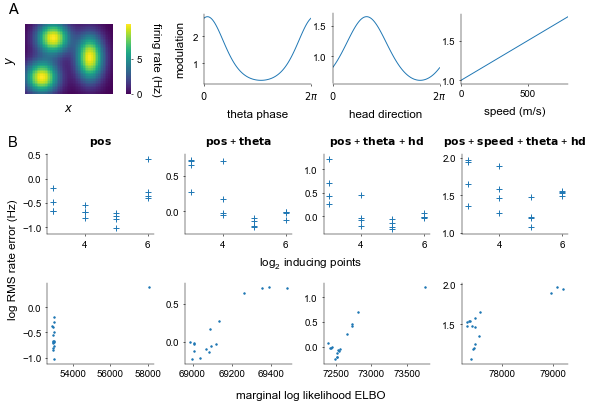

In [43]:
fig = plt.figure(figsize=(8, 5))


# visualization
fig.text(0.0, 1.0, 'A', fontsize=15)
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights, 
                        wspace=0.4, left=0., right=.25, bottom=0.77, top=.97)

ax = fig.add_subplot(spec[0, 0])
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
field = generate_data('pos', track_samples=1)[0]
ax.set_title('{:.0f} Hz'.format(field.max()), fontsize=12)
_, ax = tools.visualize_field(field, grid_shape, figax=(fig, ax), ticktitle='firing rate', 
                              ticks=[0, field.max()], ticklabels=['0', 'max'])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')


widths = [1, 1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights, 
                        wspace=0.2, left=.35, right=1., bottom=0.8, top=1.0)

ax = fig.add_subplot(spec[0, 0])
angles = np.linspace(0, 2*np.pi, 100)
angles_0 = 0.2
beta = 1.0
mod = np.exp(beta*np.cos(angles-angles_0))
ax.plot(angles, mod)
ax.set_xlabel('theta phase')
ax.set_ylabel('modulation')
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$2\pi$'])
ax.set_xlim(0, 2*np.pi)

ax = fig.add_subplot(spec[0, 1])
angles = np.linspace(0, 2*np.pi, 100)
angles_0 = 2.0
beta = 0.5
mod = np.exp(beta*np.cos(angles-angles_0))
ax.plot(angles, mod)
ax.set_xlabel('head direction')
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$2\pi$'])
ax.set_xlim(0, 2*np.pi)

ax = fig.add_subplot(spec[0, 2])
s = np.linspace(0, 800, 100)
s_mod = 0.001
mod = 1.+s*s_mod
ax.plot(s, mod)
ax.set_xlabel('speed (m/s)')
ax.set_xlim(0, 800)

# validation
fig.text(0.0, 0.62, 'B', fontsize=15)
ncols = 4
widths = [1]*ncols
heights = [1, 1]
spec = fig.add_gridspec(ncols=ncols, nrows=2, width_ratios=widths, height_ratios=heights, 
                        wspace=0.3, hspace=0.6, left=0.07, right=1., bottom=0.0, top=0.6)

n_ = np.array(num_induc_arr)[:, None].repeat(trials, axis=1)

modes = [r'$\bf{pos}$', r'$\bf{pos}$ + $\bf{theta}$', r'$\bf{pos}$ + $\bf{theta}$ + $\bf{hd}$', 
         r'$\bf{pos}$ + $\bf{speed}$ + $\bf{theta}$ + $\bf{hd}$']
for k in range(ncols):
    ax = fig.add_subplot(spec[0, k])
    ax.scatter(np.log2(n_), 0.5*np.log(R_2[k, :]), marker='+', s=50)
    ax.set_title(modes[k], pad=10, fontsize=11)

fig.text(0.54, 0.28, r'$\mathregular{log_2}$ inducing points', ha='center', fontsize=12)

for k in range(ncols):
    ax = fig.add_subplot(spec[1, k])
    #r, r_p = scstats.pearsonr(NLL[k][NLL[k] is not np.nan].flatten(), 
    #                          R_2[k][R_2[k] is not np.nan].flatten()) # Pearson r correlation test
    ax.ticklabel_format(axis='x', style='sci')
    ax.scatter(NLL[k], 0.5*np.log(R_2[k]), marker='.')
    #fig.text(0.2, 0.8, '$r={:.2f}$ ($p={:.2f}$)'.format(r, r_p), fontsize=11,
    #         transform=ax.transAxes)
    #axes[ncols+0].set_ylabel('$R^2$')
    
fig.text(0.0, 0.3, 'log RMS rate error (Hz)', va='center', rotation=90, fontsize=12)

fig.text(0.54, -0.1, 'marginal log likelihood ELBO', ha='center', fontsize=12)

plt.savefig('output/GP_validation.svg')
plt.savefig('output/GP_validation.pdf')
plt.show()

In [108]:
R_2 = np.load('saves/R_2_20201106.npy')
NLL = np.load('saves/NLL_20201106.npy')

In [37]:
import time
np.save('../data/R_2'+time.strftime("_%Y%m%d"), R_2)
np.save('../data/NLL'+time.strftime("_%Y%m%d"), NLL)

### Multi-regressor validation

In [7]:
# generate data
true_field, behav_tuple, rc_t, tbin, maxspeed = generate_data('pos_speed_theta_hd', track_samples=3000000)

Generating animal behaviour...



Computing true field...
Sampling spike trains...


In [ ]:
def compute_stats(glm_rate, t_spike): # statistics
    bs = 5000
    T = 100000
    N = int(np.ceil(T/bs))
    rate_model= []
    t_spike = t_spike[t_spike < T]

    for n in range(N):
        covariates_ = [b[n*bs:(n+1)*bs] for b in behav_data]
        rate_model += [glm_rate.eval_rate(covariates_, [0])[0]]

    rate_model = np.concatenate(rate_model)

    # Overdispersion count method
    #traj_len = 1000
    #q_cdf_, q_order_, py, T_DS, T_KS, s_DS, s_KS_, p_DS_, p_KS_, traj_lens = \
    #    stats.count_KS_method(sample_bin, t_spike, rate_model, traj_len, min_spikes=10, repeat=1)

    # ISI KS-method
    dist_isi = mdl.point_process.ISI_gamma(np.array([1.0]))
    q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS = \
        stats.ISI_KS_method(dist_isi, sample_bin, t_spike, rate_model)

    return q_cdf, Z_DS, T_KS, s_KS

def compute_NLL(glm_rate, covariates, spiketrain):
    glm_rate.eval_rate(covariates)

In [ ]:
# GP with variable regressors model fit and nonconvexity
modes = ['pos', 'pos_theta', 'pos_theta_hd', 'pos_speed_theta_hd']
folds = 10
folds_eval = 5

R_2 = []
NLL = []
for mode in modes:
    print(mode)
    R_2_ = []
    NLL_ = []
    
    # generate data
    true_field, behav_tuple, rc_t, tbin, maxspeed = generate_data(mode)
    
    cv_set = neural_utils.SpikeTrainCV(folds, rc_t[u:u+1], track_samples, behav_data)
    CVs[u, k] = neural_utils.model_cv(rate_func, cv_set)
    
    if neuron is None:
        cv_nll = []
        for ftrain, fcov, vtrain, vcov in cv_set:
            glm, _ = rate_func(fcov, ftrain)
            glm.preprocess(vcov, len(vcov[0]), vtrain, batch_size=len(vcov[0]))
            #glm.to(dev)
            cv_nll.append(glm.nll(0, cov_samples=1, ll_samples=1))
        return np.array(cv_nll)
            
    else:
        cv_nll = []
        for n in neuron:
            nll = []
            for ftrain, fcov, vtrain, vcov in cv_set:
                glm, _ = rate_func(fcov, ftrain)
                glm.preprocess(vcov, len(vcov[0]), vtrain, batch_size=len(vcov[0]))
    
    for gp_mode in modes:      
        
        R_2__ = []
        NLL__ = []
        retries = 0
        for fold in np.arange(folds_eval):
            while True:
                try:
                    covariates, kt, ind_list, units_ = GP_params(gp_mode, behav_tuple, 32, maxspeed)
                    units = 1

                    inducing_points = np.array(ind_list).T[None, ...].repeat(units_, axis=0)
                    glm_rate = mdl.nonparametrics.GP_covariates(units, inducing_points, kt,
                                                                [(None,)]*len(covariates), [(None,)]*len(covariates), 
                                                                link='exp', shared_kernel_params=True,
                                                                full_cov_fit=False, 
                                                                mean_ini=np.zeros((1, units, 1)))
                    glm_rate.set_params(tbin, jitter=1e-5)

                    renewal_dist = mdl.likelihoods.Poisson(units, 'exp')
                    renewal_dist.set_params(tbin)

                    glm = mdl.inference.nll_optimized([glm_rate], renewal_dist)
                    glm.preprocess(list(covariates), covariates[0].shape[0], rc_t, batch_size=100000)
                    glm.to(dev)

                    # fit
                    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
                    opt_tuple = (optim.Adam, 100, sch)
                    opt_lr_dict = {'default': 5*1e-2}
                    glm.set_optimizers(opt_tuple, opt_lr_dict)

                    annealing = lambda x: min(1.0, 0.002*x)

                    losses = glm.fit(3000, margin=1e1, premature=100, anneal_func=annealing, cov_samples=1, ll_samples=10, pred_ll=False)
                    break
                except (RuntimeError, AssertionError):
                    print('Retrying...')
                    if retries > 20: # max retries
                        print('Stopped.')
                        raise ValueError
                    retries += 1

            plt.figure()
            plt.plot(losses)
            plt.xlabel('epoch')
            plt.ylabel('NLL')
            plt.show()

        # rate error            
        R_2_.append()
        NLL_.append()
        
    R_2.append(R_2_)
    NLL.append(NLL_)
        
R_2 = np.array(R_2) # modes, folds
NLL = np.array(NLL)

### Multi-regressor example

In [223]:
# generate data
true_field, behav_tuple, rc_t, tbin, maxspeed = generate_data('pos_speed_theta_hd', track_samples=3000000)

Generating animal behaviour...



Computing true field...
Sampling spike trains...



Stopped at epoch 404.


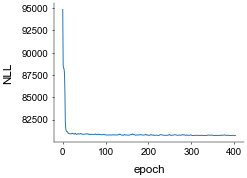

In [224]:
# GP with variable regressors model fit and nonconvexity
num_induc = 32

while True:
    try:
        covariates, kt, ind_list, units_ = GP_params('pos_speed_theta_hd', behav_tuple, num_induc, maxspeed)
        units = 1

        inducing_points = np.array(ind_list).T[None, ...].repeat(units_, axis=0)
        glm_rate = mdl.nonparametrics.GP_covariates(units, inducing_points, kt,
                                                    ([None],)*len(covariates), ([None],)*len(covariates), 
                                                    inv_link='exp', shared_kernel_params=True,
                                                    full_cov_fit=False, 
                                                    mean_ini=np.zeros((1, units, 1)), jitter=1e-5)
        glm_rate.set_params(tbin)

        #shape = np.ones(1)
        #renewal_dist = mdl.likelihoods.Gamma(units, 'exp', shape)
        renewal_dist = mdl.likelihoods.Poisson(units, 'exp')
        renewal_dist.set_params(tbin)

        glm = mdl.inference.nll_optimized([glm_rate], renewal_dist)
        glm.preprocess(list(covariates), covariates[0].shape[0], rc_t, batch_size=100000)
        glm.to(dev)

        # fit
        sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
        opt_tuple = (optim.Adam, 100, sch)
        opt_lr_dict = {'default': 5*1e-2}
        glm.set_optimizers(opt_tuple, opt_lr_dict)

        annealing = lambda x: min(1.0, 0.002*x)

        losses = glm.fit(3000, margin=1e1, premature=100, anneal_func=annealing, cov_samples=1, ll_samples=10, pred_ll=False)
        break
    except (RuntimeError, AssertionError):
        print('Retrying...')
        if retries > 20: # max retries
            print('Stopped.')
            raise ValueError
        retries += 1

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL')
plt.show()

In [225]:
place_field = []
lower_s = []
mean_s = []
upper_s = []
lower_th = []
mean_th = []
upper_th = []
lower_hd = []
mean_hd = []
upper_hd = []

# evaluate tuning
SP = 500.
TH = 2.
HD = 1.
X = [100., 100., 200.]
Y = [100., 150., 200.]
K = len(X)


# Place field
grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = (x, y, SP*np.ones_like(x), \
                  TH*np.ones_like(x), HD*np.ones_like(x))
    return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

(xx, yy), place_field_ = tools.compute_mesh(grid_size, grid_shape, func)
place_field.append(place_field_)
    
    
for n in range(K):
    # GP tuning
    steps= 100

    covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), np.linspace(0, maxspeed, steps), \
                  TH*np.ones(steps), HD*np.ones(steps))
    lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
    lower_s.append(lower[0])
    mean_s.append(mean[0])
    upper_s.append(upper[0])

    covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), SP*np.ones(steps), \
                  np.linspace(0, 2*np.pi, steps), HD*np.ones(steps))
    lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
    lower_th.append(lower[0])
    mean_th.append(mean[0])
    upper_th.append(upper[0])


    covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), SP*np.ones(steps), \
                  TH*np.ones(steps), np.linspace(0, 2*np.pi, steps))
    lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
    lower_hd.append(lower[0])
    mean_hd.append(mean[0])
    upper_hd.append(upper[0])

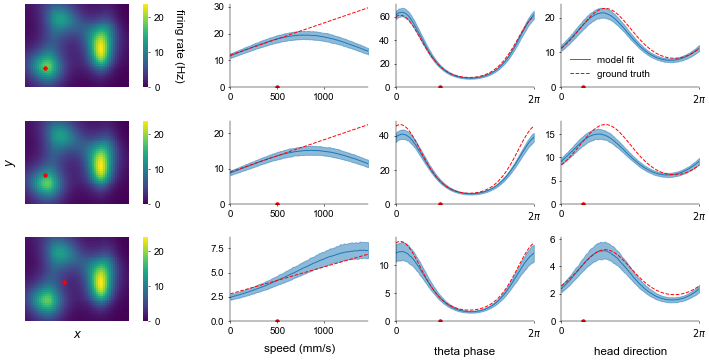

In [238]:
# example fit
fig = plt.figure(figsize=(10, 6))


# full tuning plot
widths = [1]
heights = np.ones(K)
nrows = K
ncols = 1
spec_ = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0.0, right=0.25)

# Place field
grid_extent = (left_x, right_x, bottom_y, top_y)

for k in range(K):
    ax = fig.add_subplot(spec_[k, 0])
    #ax.text(-0.08, 1.02, 'A', transform=fig.transFigure, size=15)
    if k == 0:
        ticktitle = 'firing rate (Hz)'
    else:
        ticktitle = ''
    _, ax = tools.visualize_field(place_field[0], grid_shape, ticktitle=ticktitle, figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    ax.scatter(X[k], Y[k], color='r', marker='.', s=50)
    if k == K // 2:
        ax.set_ylabel(r'$y$')
    if k == K-1:
        ax.set_xlabel(r'$x$')
    #ax.set_title(r'neuron 31', fontsize=12, pad=10)
    
    

# GP tuning
widths = [1, 1, 1]
heights = np.ones(K)
nrows = K
ncols = 3
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0.33, right=1.0)


steps= 100
y_lim = [100.0, 70.0, 35.0]


for k in range(K):
    c = np.linspace(0, maxspeed, steps)
    ax = fig.add_subplot(spec[k, 0])
    line, = ax.plot(c, mean_s[k])
    ax.fill_between(
        c, lower_s[k],
        upper_s[k], color=line.get_color(), alpha=0.5
    )
    #ax2.scatter(loc_x, loc_rate, marker='.', s=10)

    if k == K-1:
        ax.set_xlabel('speed (mm/s)')
    #ax.set_ylabel('firing rate (Hz)')
    ax.set_xlim(0, maxspeed)
    ax.scatter(SP, 0, c='r', marker='.', s=50)
    s = np.linspace(0, maxspeed, steps)
    s_mod = 0.001
    mod = 1.+s*s_mod
    ig = np.argmin(np.abs(np.linspace(0, maxspeed, steps) - SP))
    ax.plot(s, mod*mean_s[k][ig]/mod[ig], 'r--')
    ax.set_ylim(0)#, y_lim[k])
    

    c = np.linspace(0, 2*np.pi, steps)
    ax = fig.add_subplot(spec[k, 1])
    line, = ax.plot(c, mean_th[k])
    ax.fill_between(
        c, lower_th[k],
        upper_th[k], color=line.get_color(), alpha=0.5
    )
    #ax2.scatter(loc_x, loc_rate, marker='.', s=10)

    if k == K-1:
        ax.set_xlabel('theta phase')
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0, 2*np.pi])
    ax.set_xticklabels(['0', r'$2\pi$'])
    ax.scatter(TH, 0, c='r', marker='.', s=50)
    angles = np.linspace(0, 2*np.pi, steps)
    angles_0 = 0.2
    beta = 1.0
    mod = np.exp(beta*np.cos(angles-angles_0))
    ig = np.argmin(np.abs(np.linspace(0, 2*np.pi, steps) - TH))
    ax.plot(angles, mod*mean_th[k][ig]/mod[ig], 'r--')
    ax.set_ylim(0)#, y_lim[k])
    

    c = np.linspace(0, 2*np.pi, steps)
    ax = fig.add_subplot(spec[k, 2])
    line, = ax.plot(c, mean_hd[k], label='model fit')
    ax.fill_between(
        c, lower_hd[k],
        upper_hd[k], color=line.get_color(), alpha=0.5
    )
    #ax2.scatter(loc_x, loc_rate, marker='.', s=10)

    if k == K-1:
        ax.set_xlabel('head direction')
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0, 2*np.pi])
    ax.set_xticklabels(['0', r'$2\pi$'])
    ax.scatter(HD, 0, c='r', marker='.', s=50)
    angles = np.linspace(0, 2*np.pi, steps)
    angles_0 = 2.0
    beta = 0.5
    mod = np.exp(beta*np.cos(angles-angles_0))
    ig = np.argmin(np.abs(np.linspace(0, 2*np.pi, steps) - HD))
    ax.plot(angles, mod*mean_hd[k][ig]/mod[ig], 'r--', label='ground truth')
    ax.set_ylim(0)#, y_lim[k])
    
    if k == 0:
        ax.legend()
    

fig.subplots_adjust(hspace=0.4)


plt.savefig('output/GP_regressor.svg')
plt.savefig('output/GP_regressor.pdf')
plt.show()

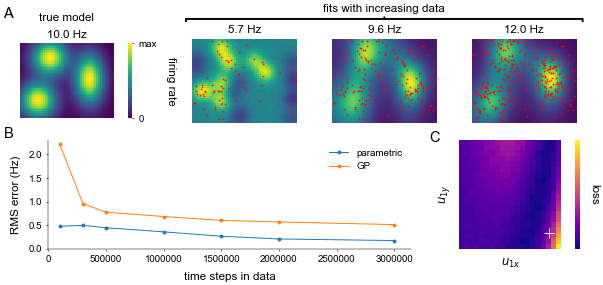

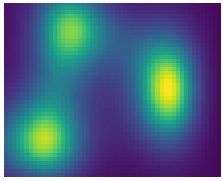

In [324]:
_, ax = tools.visualize_field(field_tuples[6], grid_shape, ticktitle='', cbar=False)

In [320]:
grid_shape = [[left_x, right_x], [bottom_y, top_y]]